# DRMM (Deep Relevance Matching Model)

_Ismaël Bonneau_


But de ce notebook: Construire une architecture DRMM fonctionnelle avec **pytorch**.

Le principe de ce notebook est de décrire et d'expliquer de façon concise le modèle DRMM et une implémentation possible.

Pour cela, 2 étapes:

- construire la chaîne de pré traitements:
    - générer des paires document-requête non pertinentes et pertinentes pour l'apprentissage
    - générer des histogrammes d'interaction locales au niveau document-requête
- construire l'architecture DRMM

Les interractions sont pour le moment des interactions locales sur des word embeddings et sont mesurées comme une similarité cosinus entre les vecteurs des mots de la requête et ceux du document.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from os import sep
import os
import random
import pickle

import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

embeddings_path = "embeddings_wiki2017"
dataset_path = "data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pré traitements: 

### Récupérer des word embeddings 

Ce word embedding a les caractéristiques suivantes:

- FastText Continuous Skipgram
- taille de vecteur ${300}$
- window ${5}$
- entrainé sur wikipédia février 2017 en langue anglaise
- pas de lemmatisation
- ${302815}$ mots

http://vectors.nlpl.eu/repository/

In [4]:
from gensim.models.wrappers import FastText #classe deprecated

model = FastText.load_fasttext_format('embeddings_wiki2017/parameters.bin')

### On Récupère les paires de pertinence/non pertinence pour chaque requête 

On génère un dictionnaire qui contient pour chaque requête en clé, un dictionnaire contenant 2 listes:
- "relevant" contenant des id de document pertinents pour la requête.
- "irrelevant" contenant des id de document non pertinents pour la requête.

In [2]:
paires = {}

with open(dataset_path + sep + "qrels.robust2004.txt", "r") as f:
    for line in f:
        lol = line.split()
        paires.setdefault(lol[0], {})
        paires[lol[0]].setdefault('relevant', []) 
        paires[lol[0]].setdefault('irrelevant', [])
        if lol[-1] == '1':
            paires[lol[0]]["relevant"].append(lol[2])
        else:
            paires[lol[0]]["irrelevant"].append(lol[2])

### On récupère les requêtes:

Elles se trouvent sous forme de tuple ([mots clés], [texte de la requête]). On ne garde que les mots clés.

In [26]:
import ast
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation

def clean(txt):
    return txt.replace(",", "").replace(".", "")

with open(dataset_path + sep + "robust2004.txt", "r") as f:
    queries = ast.literal_eval(f.read())
queries = {d:clean(queries[d][0]) for d in queries}

In [16]:
print(queries["301"])
print(queries["401"])

international organized crime
foreign minorities germany


### Le DRMM a deux entrées: une entrée interactions et une entrée termes.

L'entrée termes prend un vecteur d'idf des termes de la requête. Il faut donc pouvoir récupérer efficacement des idf. Pour cela, on construit un dictionnaire terme -> idf qui nous servira dans l'étape d'après.

In [3]:
#bon là on charge du coup vu que le fichier est sauvegardé sur le disque
idf = pickle.load(open("idf_robust2004.pkl", "rb"))

### On prépare dans des fichiers les matrices d'interactions et les vecteurs d'idf 

In [ ]:
from load_data import Dataset #permet de gérer le chargement et le traitement de robust2004

inputgenerator = Dataset(intervals=30, model_wv=model)
inputgenerator.load_idf(idf_file="idf_robust2004.pkl")
inputgenerator.load_all_query(file_query="data/robust2004.txt")
inputgenerator.load_relevance(file_rel="data/qrels.robust2004.txt")
inputgenerator.load_all_docs()

#### Cette méthode calcule les matrices d'interraction et les charge dans des fichiers

In [ ]:
inputgenerator.prepare_data_forNN("saved_data")

#### On peut maintenant récupérer les matrices d'interraction pour les utiliser

In [8]:
test_size = 0.2

query_idf = pickle.load(open("saved_data/query_idf.pkl", "rb"))

interractions_train_pos = []
interractions_train_neg = []
interractions_test_pos = []
interractions_test_neg = []

for id_requete in paires:
    if id_requete != '634':
        saintjeanlapuenta = np.load("saved_data/{}_interractions.npy".format(id_requete))
        if random.random() < test_size:
            for neg, pos in zip(saintjeanlapuenta[::2], saintjeanlapuenta[1::2]):
                interractions_test_pos.append([torch.from_numpy(pos).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
                interractions_test_neg.append([torch.from_numpy(neg).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
        else:
            for neg, pos in zip(saintjeanlapuenta[::2], saintjeanlapuenta[1::2]):
                interractions_train_pos.append([torch.from_numpy(pos).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
                interractions_train_neg.append([torch.from_numpy(neg).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])

## Architecture du modèle

### Avec pytorch

In [129]:
from torch.nn import MarginRankingLoss

#hérite de la classe Pytorch Module
class DRMM(torch.nn.Module):
    def __init__(self, hist_size, query_term_maxlen, hidden_sizes=[128,64,16,1], use_cuda=True):
        
        if hidden_sizes[-1] != 1:
            raise ValueError("la taille du dernier layer doit être 1")
            
        super(DRMM, self).__init__()
        self.MLP = [torch.nn.Linear(hist_size, hidden_sizes[0])] + [
            torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))]
        for i in range(len(self.MLP)):
            torch.nn.init.xavier_normal_(self.MLP[i].weight, gain = torch.nn.init.calculate_gain('tanh'))
            
        #initialisation du vecteur de term gating
        self.termgating = torch.nn.Linear(query_term_maxlen, query_term_maxlen, bias=False)
        torch.nn.init.xavier_normal_(self.termgating.weight, gain = torch.nn.init.calculate_gain('tanh'))
        
    #méthode forward à redéfinir
    def forward(self, interractions, termvector):
        """
        interractions: (query_term_maxlen, hist_size)
        termvector: 
        """
        #partie histogramme
        interractions_output = self.MLP[0](interractions)
        interractions_output = torch.nn.functional.tanh(interractions_output)
        for layer in self.MLP[1:]:
            interractions_output = layer(interractions_output)
            interractions_output = torch.nn.functional.tanh(interractions_output)
        interractions_output = interractions_output.squeeze() #passe de (query_term_maxlen, 1) à (1, query_term_maxlen)
        #partie term gating 
        gating_output = torch.nn.functional.softmax(self.termgating(termvector)).squeeze()
        #combiner les 2 avec un produit scalaire
        axis = 0
        #si on travaille par mini-batch:
        if len(interractions.size()) == 3:
            axis = 1
        s = torch.sum(interractions_output * gating_output, dim = axis) #dim = 0 ne marche qui pas batch.
        return s
    
    def get_model_size(self):
        """
        retourne le nombre de paramètres du modèle.
        """
        return sum([p.size(0) if len(p.size()) == 1 else p.size(0)*p.size(1) for p in self.parameters()] +
                  [p.weight.size(0)*p.weight.size(1) for p in self.MLP])
    
    def __str__(self):
        return "DRMM with {} parameters. ti as compris".format(self.get_model_size())

### On va créer une classe de Dataset qui contient les paires pertinentes et les paires non pertinentes.

Plus précisément, la classe Dataset de Pytorch est un wrapper pour X (traditionnellement les vecteurs de features) et Y (traditionnellement les labels). Ici, on a pas besoin de vecteur de labels. On peut donc transformer l'utilisation de la classe pour mettre dans X une matrice de paires (interractions relevant, vecteur de termes relevant) et dans Y la même matrice, pour les paires non pertinentes. L'avantage est que lors du shuffle avec le DataLoader, on conservera l'alignement doc pertinent/non pertinent pour une requête et on ne sera pas embêté pour utiliser la ranking hinge loss.

In [76]:
from torch.utils.data import Dataset

class DrmmDataset(Dataset):
    def __init__(self, pos_tensor, neg_tensor):
        self.x = pos_tensor
        self.y = neg_tensor
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

In [141]:
train_dataset = DrmmDataset(interractions_train_pos, 
                            interractions_train_neg)
val_dataset = DrmmDataset(interractions_test_pos,
                          interractions_test_neg)

### L'étape de création du DataLoader:

Cette classe va nous permettre de gérer le découpage en mini batches et le shuffle. C'est un wrapper pour la classe DataSet qui fournit entre autres un itérateur.

In [152]:
from torch.utils.data import DataLoader

batchsize = 512
#classe utile pour gérer les mini batches et le shuffle (crucial!)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=False)

### On regroupe toutes les étapes de forward/backprop sur un mini-batch dans une fonction:

La fonction prend deux mini batch en entrée et:

In [127]:
def drmm_make_train_step(model, loss_fn, optimizer):
    def drmm_train_step(pos_batch, neg_batch):
        #mettre le modèle en mode train
        #model.train()
        #étape forward...
        pos_score = model(pos_batch[0], pos_batch[1])
        neg_score = model(neg_batch[0], neg_batch[1])
        #calcul de la loss
        loss = loss_fn(pos_score, neg_score, torch.Tensor([1] * pos_batch[0].size()[0]))
        #calcul des gradients
        loss.backward()
        #mise à jour des paramètres
        optimizer.step()
        #reset des gradients après le passage sur ce batch
        optimizer.zero_grad()
        #retourner la loss
        return loss.item() #.item()
    
    return drmm_train_step

In [ ]:
drmm = DRMM(30, 5, hidden_sizes=[256, 128, 64, 16,1])
print(drmm)

hingeloss = MarginRankingLoss()
optimizer = torch.optim.Adam(drmm.parameters(), lr = 0.0005)

make_train_step = drmm_make_train_step(drmm, hingeloss, optimizer)

losses = []
nb_epochs = 500

for i in range(nb_epochs):
    #parcourir tous les batches du dataloader
    for pos_batch, neg_batch in train_loader:

        #pos_batch[0]: les interractions positives
        #pos_batch[1]: les query term
        #neg_batch[0]: les interractions négatives correspondantes...
        #neg_batch[1]: les query term correspondantes...

        #print(pos_batch[0].size(), pos_batch[1].size())
        loss = make_train_step(pos_batch, neg_batch)
    losses.append(loss)

DRMM with 49705 parameters. ti as compris


/home/ismael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


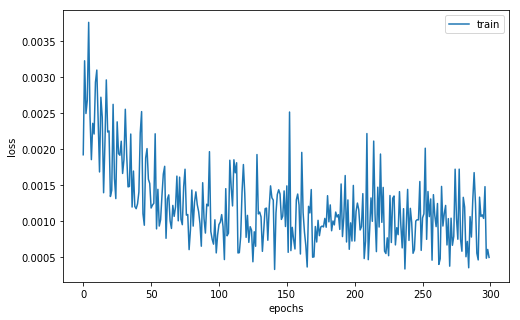

In [147]:
plt.figure(figsize=(8,5))
plt.plot(list(range(300)), losses, label="train")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()